# Second Modèle

In [1]:
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

In [2]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

import math

import copy
import time
from os import dup, dup2, close

from pulp import *

from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import seaborn as sns

from utils import *
from graphics import *

In [3]:
import pulp as pl
print(pl.__version__)
print(pl.listSolvers())
from pulp import *

2.4
['GLPK_CMD', 'PYGLPK', 'CPLEX_CMD', 'CPLEX_PY', 'CPLEX_DLL', 'GUROBI', 'GUROBI_CMD', 'MOSEK', 'XPRESS', 'PULP_CBC_CMD', 'COIN_CMD', 'COINMP_DLL', 'CHOCO_CMD', 'PULP_CHOCO_CMD', 'MIPCL_CMD', 'SCIP_CMD']


In [4]:
plt.style.use('ggplot')

In [5]:
perfs_array = perfs()

## Performance des machines

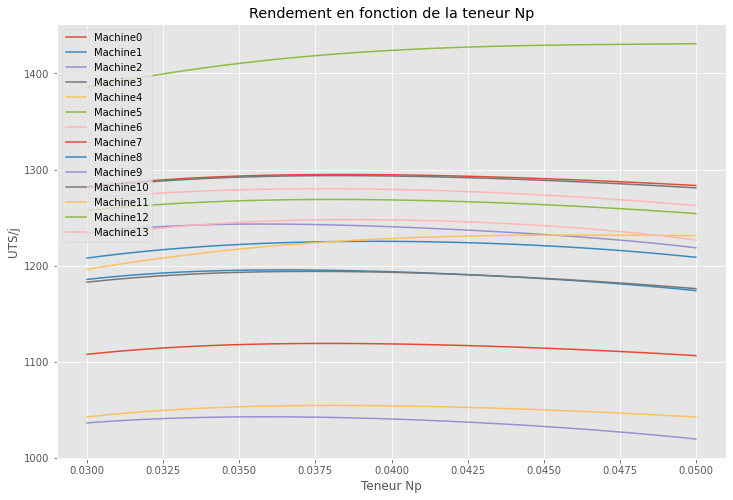

In [6]:
x = np.linspace(3,5,100)/100
Y = []
for machine in perfs_array:
    Y.append(machine(x))

plt.figure(figsize=(12,8))
for i in range(14):
    plt.plot(x,Y[i], label= "Machine"+str(i))
plt.legend()
plt.title("Rendement en fonction de la teneur Np")
plt.xlabel("Teneur Np")
plt.ylabel("UTS/j")
plt.show()

## Conversion des donnéees

In [7]:
data = pd.read_excel("data/raw/Orano-données-Double.xlsx", sheet_name="Optim", header=5, usecols=[3,4,5,6,7,14], nrows=47)
n_commandes = data.shape[0]
data['durée'] = np.abs(15000*np.random.randn(n_commandes) + 50000).astype('int')
data = data.rename(columns={"durée":"UTS"})

In [8]:
data.head()

,Commandes,ordre,disp,max,UTS,Np
0,c1,1,2021-01-01,2021-06-01,48108,0.0415
1,c2,2,2021-01-02,2021-07-01,26667,0.0410
2,c3,3,2021-01-03,2021-08-01,77268,0.0410
3,c4,4,2021-01-04,2021-09-01,52800,0.0420
4,c5,5,2021-01-05,2021-10-01,50807,0.0420


In [9]:
task_length = np.zeros((n_commandes,14))

In [10]:
for i in range(n_commandes):
    for j in range(14):
        task_length[i,j] = data.iloc[i]['UTS']/perfs_array[j](data.iloc[i]['Np'])
        
task_length[1:5,:]

array([[20.60651864, 22.35840702, 25.65378179, 22.36608126, 25.30514569,
        21.03308576, 20.855721  , 23.84948916, 21.76854731, 21.51813843,
        20.62793086, 21.68833715, 18.70651324, 21.38332603],
       [59.70767175, 64.78379246, 74.33218627, 64.80602868, 73.32200837,
        60.94365584, 60.42973902, 69.1042235 , 63.07466581, 62.34910264,
        59.76971394, 62.84225577, 54.20237992, 61.95848185],
       [40.82116994, 44.31611114, 50.85986029, 44.32353532, 50.13640868,
        41.6716046 , 41.32474157, 47.25246722, 43.12295105, 42.6547847 ,
        40.86606024, 42.91012857, 37.00489844, 42.36881251],
       [39.28032541, 42.64334581, 48.94009322, 42.65048976, 48.24394916,
        40.09865938, 39.76488911, 45.46886556, 41.49522299, 41.04472815,
        39.32352126, 41.29043376, 35.6081037 , 40.76955032]])

## CBC

In [11]:
def solvePLNEMultiMachines(disp, dmax, duree,M,bigM):    
    
    Tasks=range(len(disp)) #Liste des taches 
    Machine=range(M)
    
    model = LpProblem("Orano", LpMaximize)
    
    # Variables 
    y = LpVariable.dicts("y",((i,m) for i in Tasks for m in Machine),0,1,LpInteger) #y_{i}^m si i est usinée sur la machine m
    x = LpVariable.dicts("x", ((i,j,m) for i in Tasks for j in Tasks for m in Machine),0,1,LpInteger) #x_{i,j}^m=1 si i est usinée avant j
    deb = LpVariable.dicts("deb", Tasks,0, None)
    dem = LpVariable.dicts("dem", Tasks,0, None)
    real = LpVariable.dicts("real", Tasks,0, None)
    marge = LpVariable.dicts("marge", Tasks,0, None)
    z3 = LpVariable.dicts("z3", ((i,j,k,m) for i in Tasks for j in Tasks for k in Tasks for m in Machine),0,1,LpInteger)
    z2 = LpVariable.dicts("z2", ((i,j,m) for i in Tasks for j in Tasks for m in Machine),0,1,LpInteger)
    liv = LpVariable.dicts("liv", Tasks,0, None)
    W = LpVariable("W", lowBound=0)
    
    # Contraintes :
    for j in Tasks:
        
        for m in Machine:
            model += x[j,j,m] == 0 
            
        model += lpSum(y[j,m] for m in Machine)==1
        model += dem[j] >= disp[j]
        model += real[j] == dem[j] + lpSum(y[j,m]*duree[j,m] for m in Machine) 
        model += W <= marge[j]
        model += liv[j] == deb[j] + 30
        model += liv[j] <= dmax[j]
        model += marge[j] == dmax[j] - liv[j]
        model += deb[j] >= real[j]
       
        
        for i in Tasks:
            if i != j:
                for m in Machine: 
                    model += dem[j]>= real[i]-bigM*(1-x[i,j,m])
                    model += z2[j,i,m] <= y[i,m]
                    model += z2[j,i,m] <= y[j,m]
                    model += z2[j,i,m] >= (y[i,m]+y[j,m])-1
                    model += z2[j,i,m] >= 0
            if i<j:
                for m in Machine:
                    model += x[i,j,m]+x[j,i,m]==z2[i,j,m]

            for k in Tasks:
                if i!=j and i!=k and j!=k:
                    for m in Machine : 
                        model += z3[i,j,k,m]<=z2[i,j,m]
                        model += z3[i,j,k,m]<=z2[i,k,m]
                        model += z3[i,j,k,m]>=(z2[i,j,m]+z2[j,k,m])-1
                        model += z3[i,j,k,m]>=0
                
    # Objectif : 
    model += W
    
    #Resolution du PLNE : 
    starttime=time.time() #Pour avoir le temps d'execution
    model.solve(PULP_CBC_CMD())
    solveTime=time.time()-starttime
    
    #Affichage des éléments de résolution
    f_val=[]
    for i in range(0,len(Tasks)):
        f_val.append(model.variables()[i].varValue)
    order=np.argsort(f_val)
    print("\t CBC")
    print("Temps de résolution = ", solveTime)
    print("Statut de la solution = ", LpStatus[model.status])
    print("Valeur optimale = ", value(model.objective))
    return(solveTime,value(model.objective),model.variables())


## CBC 1.0

In [12]:
def solvePLNEMultiMachines_1_0(disp, dmax, duree,M,bigM):    
    
    Tasks=range(len(disp)) #Liste des taches 
    Machine=range(M)
    
    model = LpProblem("Orano", LpMaximize)
        
    # Variables a
    y = LpVariable.dicts("y",((i,m) for i in Tasks for m in Machine),0,1,LpInteger) #y_{i}^m si i est usinée sur la machine m
    x = LpVariable.dicts("x", ((i,j,m) for i in Tasks for j in Tasks for m in Machine),0,1,LpInteger) #x_{i,j}^m=1 si i est usinée avant j
    deb = LpVariable.dicts("deb", Tasks,0, None)
    dem = LpVariable.dicts("dem", Tasks,0, None)
    real = LpVariable.dicts("real", Tasks,0, None)
    marge = LpVariable.dicts("marge", Tasks,None, None)
    z3 = LpVariable.dicts("z3", ((i,j,k,m) for i in Tasks for j in Tasks for k in Tasks for m in Machine),0,1,LpInteger)
    z2 = LpVariable.dicts("z2", ((i,j,m) for i in Tasks for j in Tasks for m in Machine),0,1,LpInteger)
    liv = LpVariable.dicts("liv", Tasks,0, None)
    W = LpVariable("W", lowBound=0)
    
    # Contraintes :
    for j in Tasks:
        
        for m in Machine:
            model += x[j,j,m] == 0 
            
        model += lpSum(y[j,m] for m in Machine)==1
        model += dem[j] >= disp[j]
        model += real[j] == dem[j] + lpSum(y[j,m]*duree[j,m] for m in Machine) 
        model += W <= marge[j]
        model += liv[j] == deb[j] + 30
        model += liv[j] <= dmax[j]
        model += marge[j] == dmax[j] - liv[j]
        model += deb[j] >= real[j]
       
        
        for i in Tasks:
            if i != j:
                for m in Machine: 
                    model += dem[j]>= real[i]-bigM*(1-x[i,j,m])
                    model += z2[j,i,m] <= y[i,m]
                    model += z2[j,i,m] <= y[j,m]
                    model += z2[j,i,m] >= (y[i,m]+y[j,m])-1
                    model += z2[j,i,m] >= 0
            if i<j:
                for m in Machine:
                    model += x[i,j,m]+x[j,i,m]==z2[i,j,m]

            for k in Tasks:
                if i!=j and i!=k and j!=k:
                    for m in Machine : 
                        model += z3[i,j,k,m]<=z2[i,j,m]
                        model += z3[i,j,k,m]<=z2[i,k,m]
                        model += z3[i,j,k,m]>=(z2[i,j,m]+z2[j,k,m])-1
                        model += z3[i,j,k,m]>=0
           
    # Warm Start
    disp, dmax = np.array(disp), np.array(dmax)
    order = np.argsort(-np.mean(duree,axis=1), axis=0)
    duree = duree[order,]
    dmax = np.array(dmax)[order]
    disp = np.array(disp)[order]
    T, M = duree.shape[0],duree.shape[1]

    assigned = [[] for _ in range(M)]
    MAX = np.mean(duree)
    MAX = MAX*T/M*1.1
    for t in range(T):
        done = False
        i = 0
        while not done:
            m_order = np.argsort(duree[t])
            #print(t,i)
            #print("Sum : ", np.sum(duree[assigned[i],m_order[i]]) + duree[t,m_order[i]] ) 
            if np.sum(duree[assigned[i],m_order[i]]) + duree[t,m_order[i]] <MAX:
                assigned[m_order[i]].append(t)
                done = True
            else:
                i+=1
            if i>M:
                break
                
    for m in range(M):
        order = np.argsort(disp[assigned[m]])
        assigned[m] = np.array(assigned[m])[order]
    
    print("Warm Start : ")
    for m in Machine:
        for i in Tasks:
            y[i,m].setInitialValue(0)
            for j in Tasks:
                x[i,j,m].setInitialValue(0)
                z2[i,j,m].setInitialValue(0)
                for k in Tasks:
                    z3[i,j,k,m].setInitialValue(0)
    
    for m in Machine:
        n_task = len(assigned[m])
        for task in assigned[m]:
            y[task,m].setInitialValue(1)
        for i in range(n_task-1):
            succ = assigned[m][i+1:]
            main_task = assigned[m][i]
            for task in succ:
                x[main_task, task,m].setInitialValue(1)
        
        for i,j in list(itertools.combinations(assigned[m], 2)):
            z2[i,j,m].setInitialValue(1)
        for i,j,k in list(itertools.combinations(assigned[m], 3)):
            z3[i,j,k,m].setInitialValue(1)
    
    disp = [[disp[t] for t in assigned[m]] for m in range(M)]
    dmax = [[dmax[t] for t in assigned[m]] for m in range(M)]
    
    for m in Machine:
        current_timer = 0.0
        idx=0
        for task in assigned[m]:
            current_timer = max(disp[m][idx], current_timer)
            dem[task].setInitialValue(current_timer)
            real[task].setInitialValue(current_timer + duree[task,m])
            deb[task].setInitialValue(current_timer + duree[task,m])
            liv[task].setInitialValue(current_timer + duree[task,m] + 30)
            marge[task].setInitialValue(dmax[m][idx] - (current_timer + duree[task,m] + 30))
            current_timer += duree[task,m]
            idx+=1
    
    # Objectif : 
    model += W
    
    #Resolution du PLNE : 
    starttime=time.time() #Pour avoir le temps d'execution
    model.solve(PULP_CBC_CMD(warmStart=True))
    solveTime=time.time()-starttime
    
    #Affichage des éléments de résolution
    f_val=[]
    print("\t CBC WS")
    print("Temps de résolution = ", solveTime)
    print("Statut de la solution = ", LpStatus[model.status])
    print("Valeur optimale = ", value(model.objective))
    return(solveTime,value(model.objective),model.variables())


## CBC 1.1

In [13]:
def solvePLNEMultiMachines_1_1(disp, dmax, duree,M,bigM):    
    
    Tasks=range(len(disp)) #Liste des taches 
    Machine=range(M)
    
    model = LpProblem("Orano", LpMaximize)
        
    # Variables a
    y = LpVariable.dicts("y",((i,m) for i in Tasks for m in Machine),0,1,LpInteger) #y_{i}^m si i est usinée sur la machine m
    x = LpVariable.dicts("x", ((i,j,m) for i in Tasks for j in Tasks for m in Machine),0,1,LpInteger) #x_{i,j}^m=1 si i est usinée avant j
    deb = LpVariable.dicts("deb", Tasks,0, None)
    dem = LpVariable.dicts("dem", Tasks,0, None)
    real = LpVariable.dicts("real", Tasks,None, None)
    marge = LpVariable.dicts("marge", Tasks,None, None)
    z3 = LpVariable.dicts("z3", ((i,j,k,m) for i in Tasks for j in Tasks for k in Tasks for m in Machine),0,1,LpInteger)
    z2 = LpVariable.dicts("z2", ((i,j,m) for i in Tasks for j in Tasks for m in Machine),0,1,LpInteger)
    liv = LpVariable.dicts("liv", Tasks,0, None)
    W = LpVariable("W", lowBound=0)
    
    # Contraintes :
    for j in Tasks:
        
        for m in Machine:
            model += x[j,j,m] == 0 
            
        model += lpSum(y[j,m] for m in Machine)==1
        model += dem[j] >= disp[j]
        model += real[j] == dem[j] + lpSum(y[j,m]*duree[j,m] for m in Machine) 
        model += W <= marge[j]
        model += liv[j] == deb[j] + 30
        model += liv[j] <= dmax[j]
        model += marge[j] == dmax[j] - liv[j]
        model += deb[j] >= real[j]
       
        
        for i in Tasks:
            if i != j:
                for m in Machine: 
                    model += dem[j]>= real[i]-bigM*(1-x[i,j,m])
                    model += z2[j,i,m] <= y[i,m]
                    model += z2[j,i,m] <= y[j,m]
                    model += z2[j,i,m] >= (y[i,m]+y[j,m])-1
                    model += z2[j,i,m] >= 0
            if i<j:
                for m in Machine:
                    model += x[i,j,m]+x[j,i,m]==z2[i,j,m]

            for k in Tasks:
                if i!=j and i!=k and j!=k:
                    for m in Machine : 
                        model += z3[i,j,k,m]<=z2[i,j,m]
                        model += z3[i,j,k,m]<=z2[i,k,m]
                        model += z3[i,j,k,m]>=(z2[i,j,m]+z2[j,k,m])-1
                        model += z3[i,j,k,m]>=0
           
    # Warm Start
    disp, dmax = np.array(disp), np.array(dmax)
    order = np.argsort((dmax-disp) - np.mean(duree,axis=1), axis=0)
    duree = duree[order,]
    dmax = dmax[order]
    disp = disp[order]
    T, M = duree.shape[0],duree.shape[1]

    assigned = [[] for _ in range(M)]
    MAX = np.mean(duree)
    MAX = MAX*T/M*0.98
    for t in range(T):
        done = False
        i = 0
        while not done:
            m_order = np.argsort(duree[t])
            #print(t,i)
            #print("Sum : ", np.sum(duree[assigned[i],m_order[i]]) + duree[t,m_order[i]] ) 
            if np.sum(duree[assigned[i],m_order[i]]) + duree[t,m_order[i]] <MAX:
                assigned[m_order[i]].append(t)
                done = True
            else:
                i+=1
            if i>M:
                break
                
    for m in range(M):
        order = np.argsort(disp[assigned[m]])
        assigned[m] = np.array(assigned[m])[order]
    
    print("Warm Start : ")
    for m in Machine:
        for i in Tasks:
            y[i,m].setInitialValue(0)
            for j in Tasks:
                x[i,j,m].setInitialValue(0)
                z2[i,j,m].setInitialValue(0)
                for k in Tasks:
                    z3[i,j,k,m].setInitialValue(0)
    
    for m in Machine:
        n_task = len(assigned[m])
        for task in assigned[m]:
            y[task,m].setInitialValue(1)
        for i in range(n_task-1):
            succ = assigned[m][i+1:]
            main_task = assigned[m][i]
            for task in succ:
                x[main_task, task,m].setInitialValue(1)
        
        for i,j in list(itertools.combinations(assigned[m], 2)):
            z2[i,j,m].setInitialValue(1)
        for i,j,k in list(itertools.combinations(assigned[m], 3)):
            z3[i,j,k,m].setInitialValue(1)
    
    disp = [[disp[t] for t in assigned[m]] for m in range(M)]
    dmax = [[dmax[t] for t in assigned[m]] for m in range(M)]
    
    for m in Machine:
        current_timer = 0.0
        idx=0
        for task in assigned[m]:
            current_timer = max(disp[m][idx], current_timer)
            dem[task].setInitialValue(current_timer)
            real[task].setInitialValue(current_timer + duree[task,m])
            deb[task].setInitialValue(current_timer + duree[task,m])
            liv[task].setInitialValue(current_timer + duree[task,m] + 30)
            marge[task].setInitialValue(dmax[m][idx] - (current_timer + duree[task,m] + 30))
            current_timer += duree[task,m]
            idx+=1
    
    # Objectif : 
    model += W
    
    #Resolution du PLNE : 
    starttime=time.time() #Pour avoir le temps d'execution
    model.solve(PULP_CBC_CMD(warmStart=True))
    solveTime=time.time()-starttime
    
    #Affichage des éléments de résolution
    f_val=[]
    print("\t CBC WS")
    print("Temps de résolution = ", solveTime)
    print("Statut de la solution = ", LpStatus[model.status])
    print("Valeur optimale = ", value(model.objective))
    return(solveTime,value(model.objective),model.variables())


## Gurobi

In [14]:
def solvePLNEMultiMachines_2(disp, dmax, duree,M,bigM):    
    
    Tasks=range(len(disp)) #Liste des taches 
    Machine=range(M)
    
    model = LpProblem("Orano", LpMaximize)
    
    # Variables 
    y = LpVariable.dicts("y",((i,m) for i in Tasks for m in Machine),0,1,LpInteger) #y_{i}^m si i est usinée sur la machine m
    x = LpVariable.dicts("x", ((i,j,m) for i in Tasks for j in Tasks for m in Machine),0,1,LpInteger) #x_{i,j}^m=1 si i est usinée avant j
    deb = LpVariable.dicts("deb", Tasks,0, None)
    dem = LpVariable.dicts("dem", Tasks,0, None)
    real = LpVariable.dicts("real", Tasks,0, None)
    marge = LpVariable.dicts("marge", Tasks,0, None)
    z3 = LpVariable.dicts("z3", ((i,j,k,m) for i in Tasks for j in Tasks for k in Tasks for m in Machine),0,1,LpInteger)
    z2 = LpVariable.dicts("z2", ((i,j,m) for i in Tasks for j in Tasks for m in Machine),0,1,LpInteger)
    liv = LpVariable.dicts("liv", Tasks,0, None)
    W = LpVariable("W", lowBound=0)
    
    # Contraintes :
    for j in Tasks:
        
        for m in Machine:
            model += x[j,j,m] == 0 
            
        model += lpSum(y[j,m] for m in Machine)==1
        model += dem[j] >= disp[j]
        model += real[j] == dem[j] + lpSum(y[j,m]*duree[j,m] for m in Machine) 
        model += W <= marge[j]
        model += liv[j] == deb[j] + 30
        model += liv[j] <= dmax[j]
        model += marge[j] == dmax[j] - liv[j]
        model += deb[j] >= real[j]
       
        
        for i in Tasks:
            if i != j:
                for m in Machine: 
                    model += dem[j]>= real[i]-bigM*(1-x[i,j,m])
                    model += z2[j,i,m] <= y[i,m]
                    model += z2[j,i,m] <= y[j,m]
                    model += z2[j,i,m] >= (y[i,m]+y[j,m])-1
                    model += z2[j,i,m] >= 0
            if i<j:
                for m in Machine:
                    model += x[i,j,m]+x[j,i,m]==z2[i,j,m]

            for k in Tasks:
                if i!=j and i!=k and j!=k:
                    for m in Machine : 
                        model += z3[i,j,k,m]<=z2[i,j,m]
                        model += z3[i,j,k,m]<=z2[i,k,m]
                        model += z3[i,j,k,m]>=(z2[i,j,m]+z2[j,k,m])-1
                        model += z3[i,j,k,m]>=0
                
    # Objectif : 
    model += W
    
    #Resolution du PLNE : 
    starttime=time.time() #Pour avoir le temps d'execution
    model.solve(GUROBI_CMD(path="C:\\gurobi911\\win64\\bin\\gurobi_cl.exe"))
    solveTime=time.time()-starttime
    
    #Affichage des éléments de résolution
    f_val=[]
    for i in range(0,len(Tasks)):
        f_val.append(model.variables()[i].varValue)
    order=np.argsort(f_val)
    print("\t Gurobi")
    print("Temps de résolution = ", solveTime)
    print("Statut de la solution = ", LpStatus[model.status])
    print("Valeur optimale = ", value(model.objective))
    return(solveTime,value(model.objective),model.variables())


## Gurobi 2.0

In [15]:
def solvePLNEMultiMachines_2_0(disp, dmax, duree,M,bigM):    
    
    Tasks=range(len(disp)) #Liste des taches 
    Machine=range(M)
    
    model = LpProblem("Orano", LpMaximize)
        
    # Variables a
    y = LpVariable.dicts("y",((i,m) for i in Tasks for m in Machine),0,1,LpInteger) #y_{i}^m si i est usinée sur la machine m
    x = LpVariable.dicts("x", ((i,j,m) for i in Tasks for j in Tasks for m in Machine),0,1,LpInteger) #x_{i,j}^m=1 si i est usinée avant j
    deb = LpVariable.dicts("deb", Tasks,0, None)
    dem = LpVariable.dicts("dem", Tasks,0, None)
    real = LpVariable.dicts("real", Tasks,0, None)
    marge = LpVariable.dicts("marge", Tasks,None, None)
    z3 = LpVariable.dicts("z3", ((i,j,k,m) for i in Tasks for j in Tasks for k in Tasks for m in Machine),0,1,LpInteger)
    z2 = LpVariable.dicts("z2", ((i,j,m) for i in Tasks for j in Tasks for m in Machine),0,1,LpInteger)
    liv = LpVariable.dicts("liv", Tasks,0, None)
    W = LpVariable("W", lowBound=0)
    
    # Contraintes :
    for j in Tasks:
        
        for m in Machine:
            model += x[j,j,m] == 0 
            
        model += lpSum(y[j,m] for m in Machine)==1
        model += dem[j] >= disp[j]
        model += real[j] == dem[j] + lpSum(y[j,m]*duree[j,m] for m in Machine) 
        model += W <= marge[j]
        model += liv[j] == deb[j] + 30
        model += liv[j] <= dmax[j]
        model += marge[j] == dmax[j] - liv[j]
        model += deb[j] >= real[j]
       
        
        for i in Tasks:
            if i != j:
                for m in Machine: 
                    model += dem[j]>= real[i]-bigM*(1-x[i,j,m])
                    model += z2[j,i,m] <= y[i,m]
                    model += z2[j,i,m] <= y[j,m]
                    model += z2[j,i,m] >= (y[i,m]+y[j,m])-1
                    model += z2[j,i,m] >= 0
            if i<j:
                for m in Machine:
                    model += x[i,j,m]+x[j,i,m]==z2[i,j,m]

            for k in Tasks:
                if i!=j and i!=k and j!=k:
                    for m in Machine : 
                        model += z3[i,j,k,m]<=z2[i,j,m]
                        model += z3[i,j,k,m]<=z2[i,k,m]
                        model += z3[i,j,k,m]>=(z2[i,j,m]+z2[j,k,m])-1
                        model += z3[i,j,k,m]>=0
           
    # Warm Start
    order = np.argsort(-np.mean(duree,axis=1), axis=0)
    duree = duree[order,]
    dmax = np.array(dmax)[order]
    disp = np.array(disp)[order]
    T, M = duree.shape[0],duree.shape[1]

    assigned = [[] for _ in range(M)]
    MAX = np.mean(duree)*T/M
    print("MAX : ", MAX)
    for t in range(T):
        done = False
        i = 0
        while not done:
            m_order = np.argsort(duree[t])
            #print(t,i)
            #print("Sum : ", np.sum(duree[assigned[i],m_order[i]]) + duree[t,m_order[i]] ) 
            if np.sum(duree[assigned[i],m_order[i]]) + duree[t,m_order[i]] <MAX:
                assigned[m_order[i]].append(t)
                done = True
            else:
                i+=1
            if i>M:
                break
                
    for m in range(M):
        order = np.argsort(disp[assigned[m]])
        assigned[m] = np.array(assigned[m])[order]
    
    print("Warm Start : ")
    for m in Machine:
        for i in Tasks:
            y[i,m].setInitialValue(0)
            for j in Tasks:
                x[i,j,m].setInitialValue(0)
                z2[i,j,m].setInitialValue(0)
                for k in Tasks:
                    z3[i,j,k,m].setInitialValue(0)
    
    for m in Machine:
        n_task = len(assigned[m])
        for task in assigned[m]:
            y[task,m].setInitialValue(1)
        for i in range(n_task-1):
            succ = assigned[m][i+1:]
            main_task = assigned[m][i]
            for task in succ:
                x[main_task, task,m].setInitialValue(1)
        
        for i,j in list(itertools.combinations(assigned[m], 2)):
            z2[i,j,m].setInitialValue(1)
        for i,j,k in list(itertools.combinations(assigned[m], 3)):
            z3[i,j,k,m].setInitialValue(1)
    
    disp = [[disp[t] for t in assigned[m]] for m in range(M)]
    dmax = [[dmax[t] for t in assigned[m]] for m in range(M)]
    
    for m in Machine:
        current_timer = 0.0
        idx=0
        for task in assigned[m]:
            current_timer = max(disp[m][idx], current_timer)
            dem[task].setInitialValue(current_timer)
            real[task].setInitialValue(current_timer + duree[task,m])
            deb[task].setInitialValue(current_timer + duree[task,m])
            liv[task].setInitialValue(current_timer + duree[task,m] + 30)
            marge[task].setInitialValue(dmax[m][idx] - (current_timer + duree[task,m] + 30))
            current_timer += duree[task,m]
            idx+=1
    
    # Objectif : 
    model += W
    
    #Resolution du PLNE : 
    starttime=time.time() #Pour avoir le temps d'execution
    model.solve(GUROBI_CMD(path="C:\\gurobi911\\win64\\bin\\gurobi_cl.exe", warmStart=True))
    solveTime=time.time()-starttime
    
    #Affichage des éléments de résolution
    f_val=[]
    print("\t Gurobi WS")
    print("Temps de résolution = ", solveTime)
    print("Statut de la solution = ", LpStatus[model.status])
    print("Valeur optimale = ", value(model.objective))
    return(solveTime,value(model.objective),model.variables())


## GLPK

In [16]:
def solvePLNEMultiMachines_3(disp, dmax, duree,M,bigM):    
    
    Tasks=range(len(disp)) #Liste des taches 
    Machine=range(M)
    
    model = LpProblem("Orano", LpMaximize)
    
    # Variables 
    y = LpVariable.dicts("y",((i,m) for i in Tasks for m in Machine),0,1,LpInteger) #y_{i}^m si i est usinée sur la machine m
    x = LpVariable.dicts("x", ((i,j,m) for i in Tasks for j in Tasks for m in Machine),0,1,LpInteger) #x_{i,j}^m=1 si i est usinée avant j
    deb = LpVariable.dicts("deb", Tasks,0, None)
    dem = LpVariable.dicts("dem", Tasks,0, None)
    real = LpVariable.dicts("real", Tasks,0, None)
    marge = LpVariable.dicts("marge", Tasks,0, None)
    z3 = LpVariable.dicts("z3", ((i,j,k,m) for i in Tasks for j in Tasks for k in Tasks for m in Machine),0,1,LpInteger)
    z2 = LpVariable.dicts("z2", ((i,j,m) for i in Tasks for j in Tasks for m in Machine),0,1,LpInteger)
    liv = LpVariable.dicts("liv", Tasks,0, None)
    W = LpVariable("W", lowBound=0)
    
    # Contraintes :
    for j in Tasks:
        
        for m in Machine:
            model += x[j,j,m] == 0 
            
        model += lpSum(y[j,m] for m in Machine)==1
        model += dem[j] >= disp[j]
        model += real[j] == dem[j] + lpSum(y[j,m]*duree[j,m] for m in Machine) 
        model += W <= marge[j]
        model += liv[j] == deb[j] + 30
        model += liv[j] <= dmax[j]
        model += marge[j] == dmax[j] - liv[j]
        model += deb[j] >= real[j]
       
        
        for i in Tasks:
            if i != j:
                for m in Machine: 
                    model += dem[j]>= real[i]-bigM*(1-x[i,j,m])
                    model += z2[j,i,m] <= y[i,m]
                    model += z2[j,i,m] <= y[j,m]
                    model += z2[j,i,m] >= (y[i,m]+y[j,m])-1
                    model += z2[j,i,m] >= 0
            if i<j:
                for m in Machine:
                    model += x[i,j,m]+x[j,i,m]==z2[i,j,m]

            for k in Tasks:
                if i!=j and i!=k and j!=k:
                    for m in Machine : 
                        model += z3[i,j,k,m]<=z2[i,j,m]
                        model += z3[i,j,k,m]<=z2[i,k,m]
                        model += z3[i,j,k,m]>=(z2[i,j,m]+z2[j,k,m])-1
                        model += z3[i,j,k,m]>=0
                
    # Objectif : 
    model += W
    
    #Resolution du PLNE : 
    starttime=time.time() #Pour avoir le temps d'execution
    model.solve(GLPK_CMD(path="C:\\glpk-4.65\\w64\\glpsol.exe"))
    solveTime=time.time()-starttime
    
    #Affichage des éléments de résolution
    f_val=[]
    for i in range(0,len(Tasks)):
        f_val.append(model.variables()[i].varValue)
    order=np.argsort(f_val)
    print("\t GLPK")
    print("Temps de résolution = ", solveTime)
    print("Statut de la solution = ", LpStatus[model.status])
    print("Valeur optimale = ", value(model.objective))
    return(solveTime,value(model.objective),model.variables())


# Résolution 

In [17]:
# convertion des données et récupération des n premieres commandes : 
n = 15
n_machines = 6
disp, dmax = dataframe_to_list_2(data)
disp, dmax, duree = disp[:n], dmax[:n], task_length[:n,:n_machines]

In [18]:
# Résolution du PLNE avec CBC : 
[t,price,var]= solvePLNEMultiMachines(disp, dmax, duree,n_machines,10**6)

	 CBC
Temps de résolution =  13.198325157165527
Statut de la solution =  Optimal
Valeur optimale =  83.816424


In [19]:
print("Disp : ", disp)
print("Dmax : ", dmax)

Disp :  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]
Dmax :  [151.0, 181.0, 212.0, 243.0, 273.0, 304.0, 334.0, 365.0, 396.0, 424.0, 455.0, 485.0, 516.0, 546.0, 577.0]


In [20]:
# récupération des variables du plne :
demVal,debVal,livVal,realVal,real2,dem2,deb2,liv2,machine=getValues(var,n_machines, disp)

PLANIFICATION :


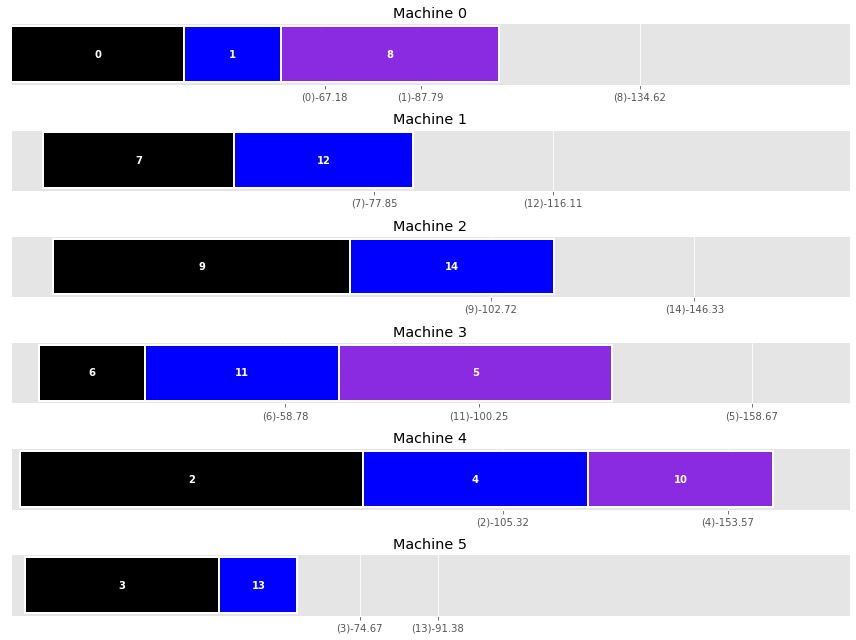

In [21]:
# Graphique représentant les emplois du temps des machines : 
showEDT(machine,deb2,dem2,real2,liv2)

MARGES : 


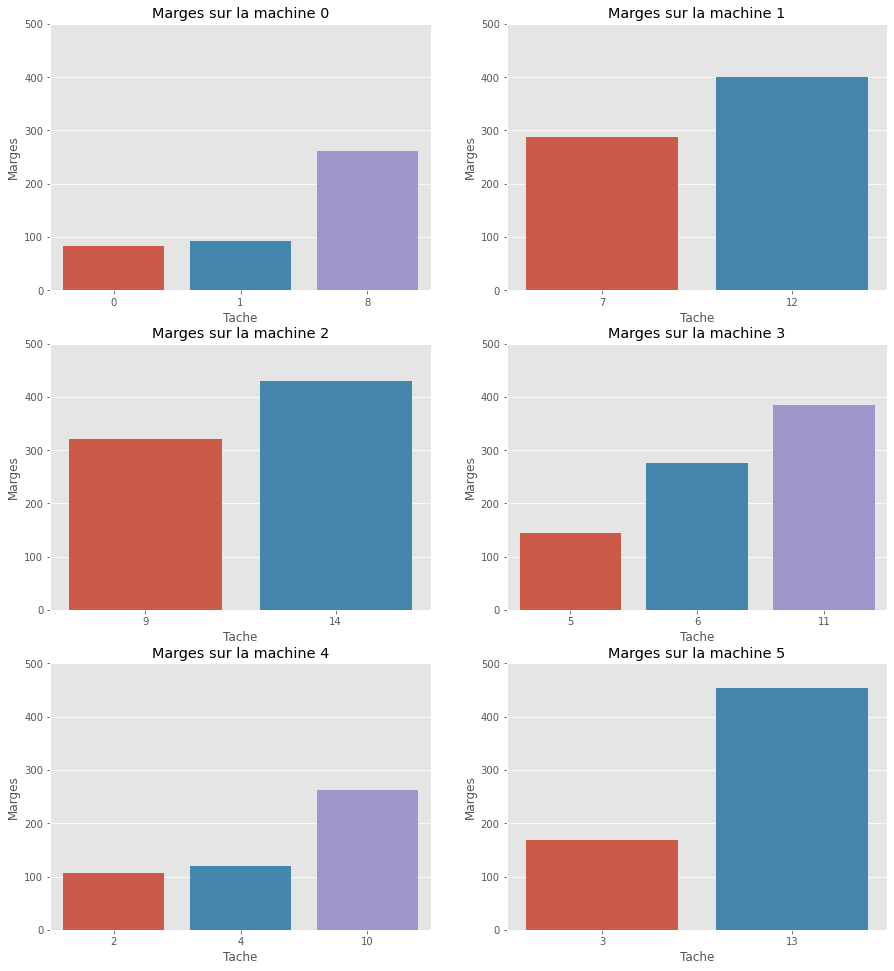

In [22]:
# Histogramme représentant la marge de chaque commande sur la machine où elle est effectuée :
showMarge(machine,livVal,dmax,n_machines)

RENDEMENTS :


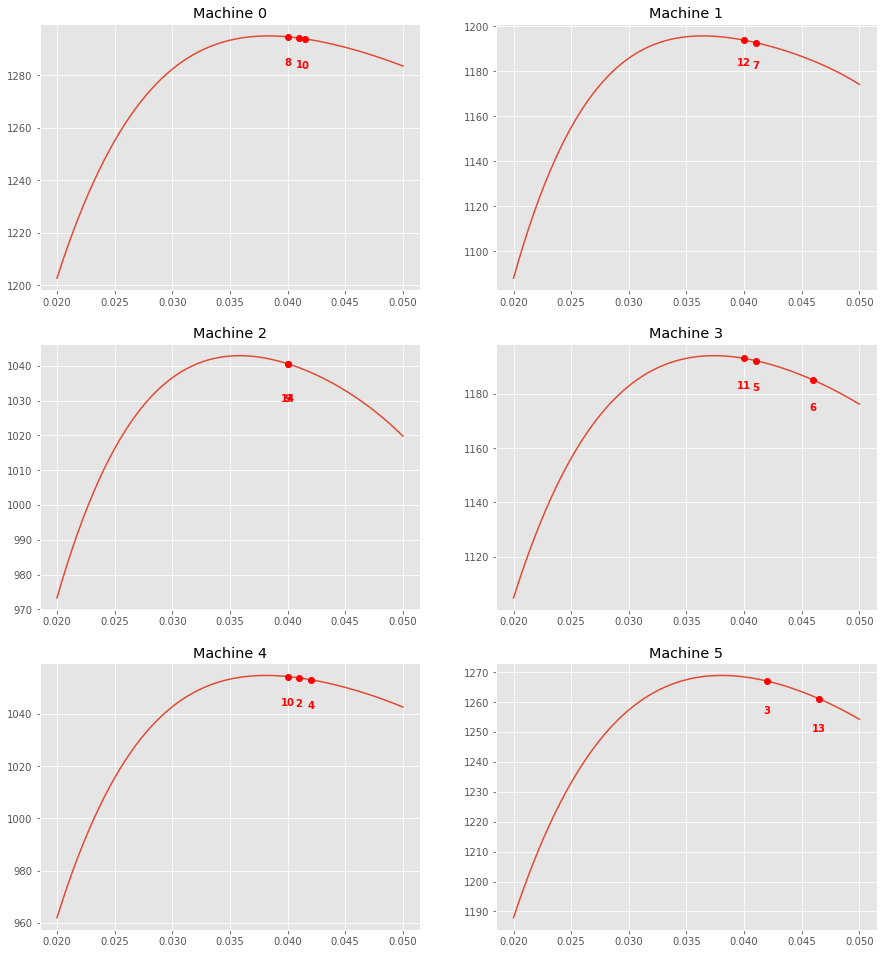

In [23]:
#Graphique représentant le rendement de la machine en fonction de la teneur en uranium désirée.
# Chaque point rouge représente une commande : 
showRendements(machine,data['Np'][:n],perfs_array)

# Courbe de Performance